In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=5)  # Print few decimal places
np.set_printoptions(suppress=True)  # Suppress scientific notation

from mipalgover.verifier import Verifier

In this tutorial we show how to use our package to verify projected gradient descent for the nonnegative least-squares problem:
$$
\begin{array}{ll}
    \text{minimize} & (1/2) \lVert Az - x \rVert^2 \\
    \text{subject to} & z \ge 0,
\end{array}
$$
where $A \in {\bf R}^{m \times n}$, $m \ge n$, $z \in {\bf R}^n$ is the decision variable, and $x \in {\bf R}^m$ parameterizes the family.

For the first order method, we choose projected gradient descent with step size $\eta > 0$, with iterates given by
$$
z^{k+1} = {\bf ReLU}(z^{k} - \eta A^T(Az^{k} - x)),
$$
where $\bf ReLU(v) = \max\{v, 0\}$ element-wise.

In this example, we choose $m = 5, n = 3$, randomly sample $A$, and parameterize $x$ as a unit box.
We also choose $\eta = 0.5/L$, where $L$ is the maximum eigenvalue of $A^T A$.
We initialize the algorithm with $z^0 = 0$.


In [36]:
np.random.seed(0)
m, n = 5, 3
A = np.random.normal(size=(m, n))
x_lb, x_ub = 10, 11
L = np.max(np.linalg.eigvals(A.T @ A))
eta = 0.5 / L
K = 10

In [37]:
solver_params = {
    'OutputFlag': 0,
}

VP = Verifier(solver_params=solver_params)
x_param = VP.add_param(m, lb=x_lb, ub=x_ub)

z0 = VP.add_initial_iterate(n, lb=1, ub=1)
z = [None for _ in range(K + 1)]
z[0] = z0

all_residuals = []
for k in range(1, K+1):
    z[k] = VP.relu_step(z[k-1] - eta * A.T @ (A @ z[k-1] - x_param))
    VP.set_infinity_norm_objective([z[k] - z[k-1]])
    res = VP.solve()
    all_residuals.append(res)

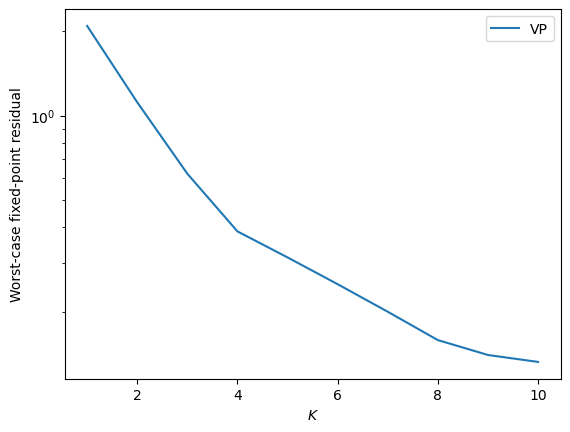

In [39]:
plt.plot(range(1, K+1), all_residuals, label='VP')
plt.yscale('log')
plt.ylabel('Worst-case fixed-point residual')
plt.xlabel(r'$K$')
plt.legend()